Import the necessary packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import plotly as px

# So that it plots locally
px.offline.init_notebook_mode(connected = True)

# Increase default plot size for all Matplotlib figures
plt.rcParams["figure.figsize"] = (27,9)        

from datetime import date
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.api import OLS

# Increase pandas default max_rows 
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

Clean the data from the source .csv file

In [2]:
# DO THIS EVERY TIME YOU ARE LOADING THE CSV FILE INTO THE IDE OR NOTEBOOK

ames = pd.read_csv('Data/Clean_Ames_Housing_Price.csv', index_col=0)

# Apply mask/filter to examine only null values.
lot_nulls = ames[ames['LotFrontage'].isna()] #lots with no linear feet of street connected to property

# Group lots by configuration
grouped_lots = ames.groupby(['LotConfig']).agg({
   'LotFrontage' : 'mean', 
})

# Replace np.nan with average for lot_config of that type
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'Corner'), 'LotFrontage'] = 81.468023
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'CulDSac'), 'LotFrontage'] = 56.456790        
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'FR2'), 'LotFrontage'] = 59.413793        
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'FR3'), 'LotFrontage'] = 79.3       
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'Inside'), 'LotFrontage'] = 66.633846

# Clean NaN values with proper coding
ames['Alley'] = ames['Alley'].replace(np.nan, 'NA')
ames['BsmtQual'] = ames['BsmtQual'].replace(np.nan, 'NA')
ames['BsmtCond'] = ames['BsmtCond'].replace(np.nan, 'NA')
ames['BsmtExposure'] = ames['BsmtExposure'].replace(np.nan, 'NA')
ames['BsmtFinType1'] = ames['BsmtFinType1'].replace(np.nan, 'NA')
ames['BsmtFinSF1'] = ames['BsmtFinSF1'].replace(np.nan, 0)
ames['BsmtFinType2'] = ames['BsmtFinType2'].replace(np.nan, 'NA')
ames['BsmtFinSF2'] = ames['BsmtFinSF2'].replace(np.nan, 0)
ames['BsmtUnfSF'] = ames['BsmtUnfSF'].replace(np.nan, 0)
ames['TotalBsmtSF'] = ames['TotalBsmtSF'].replace(np.nan, 0)
ames['BsmtFullBath'] = ames['BsmtFullBath'].replace(np.nan, 0)
ames['BsmtHalfBath'] = ames['BsmtHalfBath'].replace(np.nan, 0)
ames['Electrical'] = ames['Electrical'].replace(np.nan, 'SBrkr')
ames['FireplaceQu'] = ames['FireplaceQu'].replace(np.nan, 'NA')
ames['GarageType'] = ames['GarageType'].replace(np.nan, 'NA')
ames['GarageYrBlt'] = ames['GarageYrBlt'].replace(np.nan, 'NA')
ames['GarageFinish'] = ames['GarageFinish'].replace(np.nan, 'NA')
ames['GarageCars'] = ames['GarageCars'].replace(np.nan, 0)
ames['GarageArea'] = ames['GarageArea'].replace(np.nan, 0)
ames['GarageQual'] = ames['GarageQual'].replace(np.nan, 'NA')
ames['GarageCond'] = ames['GarageCond'].replace(np.nan, 'NA')
ames['PoolQC'] = ames['PoolQC'].replace(np.nan, 'NA')
ames['Fence'] = ames['Fence'].replace(np.nan, 'NA')
ames['MiscFeature'] = ames['MiscFeature'].replace(np.nan, 'NA')

# Inspect the property records to see front façades
# https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=2&PageID=1104
ames['MasVnrType'].loc[176] = "Stone"
ames['MasVnrType'].loc[359] = "None"
ames['MasVnrType'].loc[754] = "None"
ames['MasVnrType'].loc[788] = "None"
ames['MasVnrType'].loc[872] = "None"
ames['MasVnrType'].loc[892] = "None"
ames['MasVnrType'].loc[952] = "Stone"
ames['MasVnrType'].loc[1042] = "None"
ames['MasVnrType'].loc[1162] = "None"
ames['MasVnrType'].loc[1356] = "None"
ames['MasVnrType'].loc[1554] = "None"
ames['MasVnrType'].loc[2034] = "None"
ames['MasVnrType'].loc[2478] = "None"
ames['MasVnrType'].loc[2537] = "None"

# For the properties with partial height stone façade, assume 4 ft height,
# and for full height, assume 8 ft height
# Assume façade length is the 1.618 length of a house built in the footprint of a golden ration
# sqrt(1.618 * 1stFlrSF)
ames['MasVnrArea'].loc[176] = 4 * (1.618 * ames.loc[176]['1stFlrSF']) ** 0.5
ames['MasVnrArea'].loc[359] = 0
ames['MasVnrArea'].loc[754] = 0
ames['MasVnrArea'].loc[788] = 0
ames['MasVnrArea'].loc[872] = 0
ames['MasVnrArea'].loc[892] = 0
ames['MasVnrArea'].loc[952] = 8 * (1.618 * ames.loc[176]['1stFlrSF']) ** 0.5
ames['MasVnrArea'].loc[1042] = 0
ames['MasVnrArea'].loc[1162] = 0
ames['MasVnrArea'].loc[1356] = 0
ames['MasVnrArea'].loc[1554] = 0
ames['MasVnrArea'].loc[2034] = 0
ames['MasVnrArea'].loc[2478] = 0
ames['MasVnrArea'].loc[2537] = 0

# ames.to_csv('Data/Clean_Ames_HousePrice.csv')

/Users/jchatterjee/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Import the cleaned data into a new dataframe

In [3]:
# Analysis of Ames_HousePrice.csv starts here
data_House_price=ames

There are houses with no garages that still need values assigned to them for the year built. So, for simplicity those cases shall be the year the house was built or remodeled, whichever was more recent.

In [4]:
# Assign dummy values for houses with garages that do not have them
no_garage = data_House_price.loc[data_House_price.GarageYrBlt == 'NA'].index.to_list()
for i in no_garage:
    data_House_price.loc[i,'GarageYrBlt'] = max(data_House_price.loc[i,'YearBuilt'],data_House_price.loc[i,'YearRemodAdd'])

Assess the number of unique parcels denoted by PID.

In [5]:
pid=data_House_price.PID.unique()
print(data_House_price['PID'].value_counts())
print(data_House_price.shape)

909276070    2
909176150    1
528292070    1
909250220    1
534450150    1
            ..
531452260    1
528488130    1
923229010    1
528382020    1
906223180    1
Name: PID, Length: 2579, dtype: int64
(2580, 81)


Further cleaning of data to be performed.

In [6]:
# Remove duplicates
data_House_price=data_House_price.drop_duplicates(subset=None, keep='first', inplace=False)
duplicate_obersvation = data_House_price[data_House_price.duplicated()]

# Create new column since built or remodeled
data_House_price['YearRemodAdd']
data_House_price['YearSinceBuiltRemodeled']=data_House_price['YrSold']-data_House_price['YearRemodAdd']

/var/folders/kg/5clnm8vj1jz2tlvmfxjvq3_00000gn/T/ipykernel_1562/1236823908.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Encode various variables and perform **Multilinear Regression**.

In [7]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#Numerical:
#LotArea, GrLivArea, YearBuilt,BedroomAbvGr,

#Nominal Categorical:
    
    #BldgType :1Fam,2FmCon,TwnhsE,Twnhs,Duplex
    #OverallQual
    #OverallCond
    #LandSlope: Gtl,Mod,Sev
    
#conditional:
    #PavedDrive,MSZoning
    
multi_linear_var=data_House_price[['SalePrice','LotArea', 'GrLivArea', 'BedroomAbvGr','LandSlope','YearBuilt', \
                                   'MSZoning','BldgType','OverallQual','OverallCond','PavedDrive']]    

multi_linear_var

enc = OrdinalEncoder()
enc.fit(multi_linear_var[["OverallQual","BldgType","OverallCond","LandSlope"]])
multi_linear_var[["OverallQual","BldgType","OverallCond","LandSlope"]] = enc.transform(multi_linear_var[["OverallQual","BldgType","OverallCond","LandSlope"]])

multi_linear_var = pd.get_dummies(multi_linear_var, columns = ['PavedDrive'],drop_first = True)
multi_linear_var = pd.get_dummies(multi_linear_var, columns = ['MSZoning'],drop_first = True)

x2=multi_linear_var.iloc[: , 1:]
y2=multi_linear_var['SalePrice']

ols2 = linear_model.LinearRegression()
lm_test2=ols2.fit(x2, y2)
print(lm_test2.score(x2, y2))
###################Summary

features2 = sm.add_constant(x2)
ols_sm2   = OLS(y2,features2)
lm_test2_1    = ols_sm2.fit()

print(lm_test2_1.summary())

0.8116536008490594
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     690.0
Date:                Sun, 22 May 2022   Prob (F-statistic):               0.00
Time:                        00:12:52   Log-Likelihood:                -30458.
No. Observations:                2579   AIC:                         6.095e+04
Df Residuals:                    2562   BIC:                         6.105e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.2

/Users/jchatterjee/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jchatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



Further refine the data to exclude more irrelevant variables

In [8]:
# Removing Mszoning FV, C, I, A
data_House_price = data_House_price[(data_House_price['MSZoning']!='FV')]
data_House_price = data_House_price[(data_House_price['MSZoning']!='C (all)')]
data_House_price = data_House_price[(data_House_price['MSZoning']!='I (all)')]
data_House_price = data_House_price[(data_House_price['MSZoning']!='A (agr)')]

# Only include houses the were sold under normal conditions
data_House_price = data_House_price[(data_House_price['SaleCondition']=='Normal')]

# Remove type of street, miscellaneous features, and utilities from the model
data_House_price=data_House_price.drop(['Street','MiscFeature','Utilities'], axis=1)

(2305, 79)

Simplify month of sale into seasons.

In [9]:
def get_season(mnth):
    if (mnth in {12,1,2}):
        return("Winter")
    if (mnth in {3,4,5}):
        return("Spring")
    if (mnth in {6,7,8}):
        return("Summer")
    if (mnth in {9,10,11}):
        return("Autumn")
    
data_House_price['Season'] = data_House_price.apply (lambda row : get_season(row['MoSold']), axis=1)    
#print(get_season(data_orders['Order.Date'][1]))

Clean and refine the data further to encode and simplify more variables.

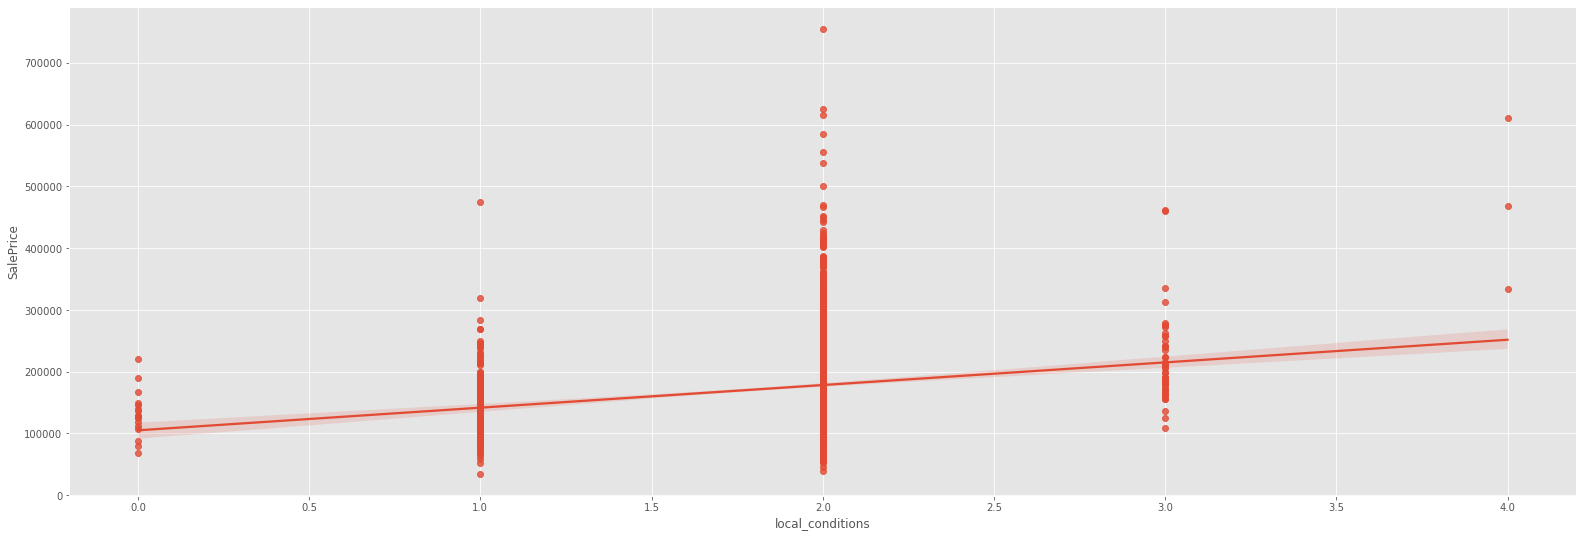

In [10]:
tmp=data_House_price

tmp['Alley']=tmp['Alley'].replace({'Grvl':1, 'Pave': 1, 'NA': 0})
tmp['CentralAir']=tmp['CentralAir'].replace({'Y': 1, 'N': 0})

####################merging condition1 and condition2 into one feature###################################
#2 if by positive feature, 1 if normal, 0 if negative feature. 
import seaborn as sns
tmp['Condition2'].unique()
tmp['positive_condition1'] = tmp['Condition1']
tmp['positive_condition2'] = tmp['Condition2']
tmp_condition_columns = tmp[['positive_condition2', 'positive_condition1']]

dict_ordinal = {
   'Artery':0,
    'RRNe':0,
    'RRAe':0,
    'Feedr':0,
    'RRAn':0,
    'Norm':1,
    'RRNn':0,
    'PosN':2,
    'PosA':2,
        }

# Loop to get the job done
for i in tmp_condition_columns.columns:
    tmp.replace({i: dict_ordinal},inplace = True)

tmp['local_conditions'] = tmp['positive_condition1']+tmp['positive_condition2']
# This a combined measure of local features. Railroads and busy streets are just not quite as nice
# to live by as are greenbelts and parks and even normal places

sns.regplot(x=tmp['local_conditions'],y=tmp['SalePrice'])
tmp=tmp.drop(['positive_condition1','positive_condition2'],axis=1)

###########################################################################################################

tmp['Electrical']=tmp['Electrical'].replace({'SBrkr':1, 'FuseA': 0, 'FuseF': 0, 'FuseP': 0})
tmp['PavedDrive']=tmp['PavedDrive'].replace({'Y':1, 'N': 0, 'P': 0})

###################################################################################################
tmp['SaleType']=tmp['SaleType'].replace({'WD':'Warranty_Deed', 'CWD': 'Warranty_Deed', 'VWD': 'Warranty_Deed',
                                     'Con':'Contract', 'ConLw':'Contract', 'ConLI':'Contract',
                                     'ConLD':'Contract', 'New':'Other', 'COD':'Other', 'Oth':'Other' })

###############################################################################################################
tmp['PoolArea']=tmp['PoolArea'].where(tmp['PoolArea'] == 0, 1)
###############################################################################################################

data_House_price=tmp

Dummify various ordinal variables.

In [11]:
########################################Add all cleaning before this##################################################
# Decide how to map string values to numerical values for ordinal variables
Ordstr = ['ExterQual','ExterCond', 'BsmtQual','HeatingQC','KitchenQual', 
          'Fence','MasVnrType','LotShape','Foundation','GarageFinish']

ord2dummies01 = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
ord_vars01 = ['ExterQual','ExterCond','HeatingQC','KitchenQual']

ord2dummies02 = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, "NA":0}
ord_vars02 = ['BsmtQual']

# ord2dummies03 = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
# ord_vars03 = ['BsmtExposure']

# ord2dummies04 = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
# ord_vars04 = ['BsmtFinType1','BsmtFinType2']

ord2dummies06 = {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0}
ord_vars06 = ['Fence']

ord2dummies07 = {'Stone':4,'BrkCmn':3,'BrkFace':2,'CBlock':1,'None':0}
ord_vars07 = ['MasVnrType']

ord2dummies08 = {'Reg':3,'IR1':2,'IR2':1,'IR3':0}
ord_vars08 = ['LotShape']

# ord2dummies09 = {'PConc':5,'Slab':4,'CBlock':3,'BrkTil':2,'Stone':1,'Wood':0}
# ord_vars09 = ['Foundation']

ord2dummies10 = {'Fin':3,'RFn':2,'Unf':1,'NA':0}
ord_vars10 = ['GarageFinish']

In [12]:
# Map the values in the dataframe
for i in ord_vars01:
    data_House_price[i].replace(ord2dummies01, inplace=True)

for i in ord_vars02:
    data_House_price[i].replace(ord2dummies02, inplace=True)
    
# for i in ord_vars03:
#     data_House_price[i].replace(ord2dummies03, inplace=True)

# for i in ord_vars04:
#     data_House_price[i].replace(ord2dummies04, inplace=True)    

for i in ord_vars06:
    data_House_price[i].replace(ord2dummies06, inplace=True)
    
for i in ord_vars07:
    data_House_price[i].replace(ord2dummies07, inplace=True)

for i in ord_vars08:
    data_House_price[i].replace(ord2dummies08, inplace=True)

# for i in ord_vars09:
#     data_House_price[i].replace(ord2dummies09, inplace=True)
    
for i in ord_vars10:
    data_House_price[i].replace(ord2dummies10, inplace=True)
    
# Assign a binary value for whether or not a house has a pool
#data_House_price.loc[data_House_price['PoolArea'] > 0] = 1

Dummify various nominal variables.

In [13]:
Nomstr = ['MSZoning','Alley','LandContour','LotConfig','Neighborhood','local_conditions','HouseStyle','RoofStyle', \
          'MasVnrType','CentralAir','Electrical','PavedDrive','SaleType','PoolArea','Foundation','Season']
for i in Nomstr:   
    dummy = pd.get_dummies(data_House_price[i], prefix=i, prefix_sep='__')
    dummy = dummy.drop(i+'__'+str(data_House_price[i].mode()[0]), axis=1)
    data_House_price = pd.concat([data_House_price.drop(i, axis=1), dummy], axis=1)

In [14]:
##########################Nearest Neighbor here##################################
# tmp1=data_House_price
# from sklearn.neighbors import NearestNeighbors
# X_nei = tmp1['Neighborhood']
# X_nei.unique()
# n_nei=X_nei.shape[0]//6
# neigh = NearestNeighbors(n_neighbors=n_nei)
# neigh.fit(X_nei)
# NearestNeighbors(n_neighbors=n_nei)
# A = neigh.kneighbors_graph(X)

Check for columns missing data.

In [15]:
missingCols = np.sum(data_House_price.isnull())
print(missingCols[missingCols>0])

Series([], dtype: int64)


Drop various variables and perform **Logistic Regression**.

In [16]:
x = data_House_price.drop(['PID','SalePrice','MSSubClass','Condition1','Condition2','BldgType','YearBuilt','YearRemodAdd', \
                           'RoofMatl','Exterior1st','Exterior2nd','MasVnrArea','BsmtCond','BsmtExposure','BsmtFinType1', \
                           'BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','Heating','2ndFlrSF','BsmtFullBath', \
                           'BsmtHalfBath','BedroomAbvGr','KitchenAbvGr','Functional','FireplaceQu', 'GarageType', \
                           'GarageYrBlt','GarageCars','GarageQual','GarageCond','PoolQC','MiscVal','Alley__1','LotShape', \
                           'MoSold'],axis=1)

# These are the parameters for which a logistic regression shall me performed
x_log = ['GrLivArea','LotArea','TotalBsmtSF','LotFrontage','1stFlrSF']
x_log_index = x.index.to_list()

# Bump up values for zero in order to compute logistic regression
for j in x_log:
    for i in x_log_index:
        if x[j][i] == 0:
            x[j][i] += 0.001
        else:
            pass

# Convert the independent variables parameters selected above to a logistic regression range
for j in x_log:
    x[j] = np.log(x[j])

y = data_House_price['SalePrice']
y = np.log(y)

# To convert whatever strings your data might contain to numeric values. 
# If they're incompatible with conversion, they'll be reduced to NaNs.
x = x.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')
x.fillna(0, inplace=True)
y.fillna(0, inplace=True)

# Importing train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

# Importing module
from sklearn.linear_model import LinearRegression

# Creating an object of LinearRegression class
LR = LinearRegression()

# Fitting the training data
LR.fit(x_train,y_train)

print("Intercept: %f" %LR.intercept_)
print("Coefficients: %s" %str(LR.coef_))
print("R^2: %f" %(LR.score(x_train,y_train)))
print("R^2: %f" %(LR.score(x_test,y_test)))

features20 = sm.add_constant(x_train)
ols_sm20   = OLS(y_train,features20)
lm_test20    = ols_sm20.fit()

print(lm_test20.summary())

Intercept: 9.570264
Coefficients: [ 3.82738551e-01  2.53233961e-02  9.13983420e-02 -3.53030994e+09
  5.64767171e-02  3.78329028e-02  1.93453359e-02  1.06858072e-02
  3.45310676e-02  7.20157474e-03  1.40236989e-02  6.87479489e-02
 -9.03606415e-05  7.52576441e-03  1.97613910e-02  3.33556533e-02
 -5.62763214e-03  2.95867100e-02  1.63859501e-02  1.52349472e-04
  5.96046448e-05  1.70588493e-04  5.44190407e-05  1.76012516e-04
  1.92105770e-04  1.20437890e-03 -1.37869362e-03 -9.58867605e+06
 -4.83632088e-04 -6.26366442e-02 -2.74765259e-02 -2.39711099e-02
  2.18013469e-02  4.57235933e-02 -1.86866677e-02 -2.24243500e-04
 -4.89565071e-02 -3.38905965e-02  8.37731893e-02  6.84129340e-02
  7.72652198e-02  4.91403600e-02  5.68193272e-02  4.74276384e-02
  9.41953305e-02 -2.77270311e-02  2.71840673e-02  1.25802848e-01
  5.86269340e-01 -5.30043524e-03  5.64678993e-02 -3.52752483e-02
  3.32225934e-02  9.74587736e-02  6.21251436e-03  1.54085527e-01
  1.32237094e-01 -4.62336077e-02 -2.42370809e-03  2.3704

/var/folders/kg/5clnm8vj1jz2tlvmfxjvq3_00000gn/T/ipykernel_1562/2122231980.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jchatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



Perform **Huber Regression** to evaluate the effect of removing outliers.

In [17]:
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(max_iter = 1000).fit(x_train, y_train)
huber.score(x_test, y_test)


/Users/jchatterjee/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



0.9054350190492275

Import packages for performing the **Penalized Regression** methods.

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import datasets

Perform **Ridge Regression**.

In [19]:
ridge = Ridge()
ridge.fit(x_train, y_train)
print('the ridge intercept is: %.2f' %(ridge.intercept_))
#pd.Series(ridge.coef_, index=house_features.columns)
ridge.score(x_test, y_test)

the ridge intercept is: 9.89


0.9284828392447706

Perform **Lasso Regression**.

In [20]:
lasso  = Lasso()
alphas = np.linspace(0.001,1.1,20)
lasso.set_params(normalize=False)
coefs_lasso  = []
score_lasso  = []

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(x_train, y_train)  
        coefs_lasso.append(lasso.coef_)
        score_lasso.append(lasso.score(x_test, y_test))

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = x.columns)  
#print(coefs_lasso.head())
score_lasso

[0.9280841289032938,
 0.7876134755673568,
 0.6735566322130062,
 0.5806021607293974,
 0.580724274601164,
 0.5807552984745492,
 0.5806134534830795,
 0.5802987719746174,
 0.5798113389655144,
 0.5791510569143472,
 0.5783179258211159,
 0.5773119459112778,
 0.5761331170397104,
 0.5747814390920374,
 0.5732569120682598,
 0.571559535968377,
 0.5696893107923888,
 0.5676462365341632,
 0.5654303133315244,
 0.563041541191518]

Perform **ElasticNet Regression**.

In [21]:
elasticnet = ElasticNet(alpha=0.00001, l1_ratio=0.5, normalize=True)
elasticnet.fit(x, y)
print(r'The R^2 is %.2f' %(elasticnet.score(x, y)))
elasticnet.coef_,  elasticnet.intercept_

The R^2 is 0.93


(array([ 2.89952980e-01,  2.59020307e-02,  9.05364734e-02,  0.00000000e+00,
         5.75817581e-02,  3.50904618e-02,  2.33213045e-02,  3.06911529e-03,
         3.33814675e-02,  5.83022354e-03,  1.27179833e-02,  1.25973634e-01,
        -8.76238766e-05,  1.79535715e-02,  2.26950920e-02,  3.25816768e-02,
        -3.12403955e-03,  3.19051629e-02,  1.55085836e-02,  1.51696615e-04,
         7.10927249e-05,  1.30879753e-04,  5.53621328e-05,  4.11568572e-05,
         1.86322924e-04,  2.70694821e-04, -1.23819082e-03,  0.00000000e+00,
        -5.88202053e-04, -4.10762625e-02, -2.19536392e-02, -2.14727502e-02,
         2.75015241e-02,  2.25860083e-02, -1.65973440e-02,  1.01224483e-02,
        -3.52103841e-02, -2.42890670e-02,  4.81471713e-02,  9.18354489e-02,
         4.32868557e-02,  3.04464128e-02,  5.36287844e-02,  3.15845910e-02,
         8.50818552e-02, -4.16664750e-02,  1.00897891e-02,  1.13742565e-01,
         5.38851269e-01, -2.61111647e-02,  1.08390510e-02, -4.19250804e-02,
         1.7

Perform **Random Forest Regression**.

In [22]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)
# Train the model on training data
rf.fit(x_train, y_train)
rf.score(x_test,y_test)

0.912384985882531

Perform **Support Vector Machines Regression**.

In [29]:
# # Import svm model
# from sklearn import svm

# # Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics

# # Import scikit-learn modules for encoding data
# from sklearn import preprocessing
# from sklearn import utils

# # Create a svm Classifier
# clf = svm.SVC(kernel='linear') # Linear Kernel

# # Convert y values to categorical values
# lab = preprocessing.LabelEncoder()
# y_transformed_train = lab.fit_transform(y_train)
# y_transformed_test = lab.fit_transform(y_test)

# # Train the model using the training sets
# clf.fit(x_train, y_transformed_train)

# # Predict the response for test dataset
# y_pred = clf.predict(x_test)

# # Model Accuracy: how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_transformed_test, y_pred))

Accuracy: 0.0021691973969631237
